In [1]:
import json
import os

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from geopandas import GeoDataFrame
from matplotlib.lines import Line2D
from shapely.geometry import LineString, Point

ox.settings.log_console = False
ox.settings.use_cache = True

In [2]:
from constants import (
    AGGR_GRAPH_PATH,
    CITYLINES_DATA_DIR,
    CITYLINES_SRCS,
    LHR_LAT,
    LHR_LON,
    LHR_NAME_STR,
    METRO_ROUTES_FPATH,
    OSMNX_DATA_DIR,
    POP_READING_RADIUS,
    SPEEDO_ROUTES_FPATH,
    WORLDPOP_DATA_DIR,
    WORLDPOP_URL,
)

os.makedirs(WORLDPOP_DATA_DIR, exist_ok=True)
os.makedirs(OSMNX_DATA_DIR, exist_ok=True)
os.makedirs(CITYLINES_DATA_DIR, exist_ok=True)

## Download: Worldpop Data


In [4]:
def fetch_worldpop_data(url: str, data_dir: str) -> str:
    os.makedirs(data_dir, exist_ok=True)

    zip_fname = url.split("/")[-1]
    zip_fpath = os.path.join(data_dir, zip_fname)
    csv_fname = zip_fname.replace(".zip", ".csv")
    csv_fpath = os.path.join(data_dir, csv_fname)

    # Download if missing
    if not os.path.exists(zip_fpath):
        print(f"Downloading {zip_fname}...")

        import requests

        resp = requests.get(url, stream=True)
        resp.raise_for_status()

        with open(zip_fpath, "wb") as f:  # binary mode
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        print(f"Saved -> {zip_fpath}")
    else:
        print(f"{zip_fname} already exists. Skipping download.")

    # Unzip if needed
    if not os.path.exists(csv_fpath):
        print(f"Extracting {csv_fname}...")

        import zipfile

        with zipfile.ZipFile(zip_fpath, "r") as archive:
            archive.extractall(data_dir)

        print(f"Extracted to {data_dir}")
    else:
        print(f"{csv_fname} already exists. Skipping extraction.")

    return csv_fpath


WORLDPOP_CSV_FPATH = fetch_worldpop_data(WORLDPOP_URL, WORLDPOP_DATA_DIR)

print("WorldPop CSV ready at:", WORLDPOP_CSV_FPATH)

pak_pd_2020_1km_UNadj_ASCII_XYZ.zip already exists. Skipping download.
pak_pd_2020_1km_UNadj_ASCII_XYZ.csv already exists. Skipping extraction.
WorldPop CSV ready at: ../data/worldpop\pak_pd_2020_1km_UNadj_ASCII_XYZ.csv


## Setup Lahore's Boundary


In [3]:
lhr_boundary: GeoDataFrame = ox.geocode_to_gdf(
    LHR_NAME_STR
)  # Get administrative Boundary for Lahore


lhr_cntr_gdf: GeoDataFrame = (
    gpd.GeoDataFrame(  # create gdf w/ single point i.e Lahore's center
        {"geometry": [Point(LHR_LON, LHR_LAT)]},
        crs="EPSG:4326",  # WGS84
    )
)

lhr_cntr_gdf_utm = ox.projection.project_gdf(
    lhr_cntr_gdf
)  # Ensure Lahore's gdf is in the UTM CRS

#### Plot Lahore's Boundary


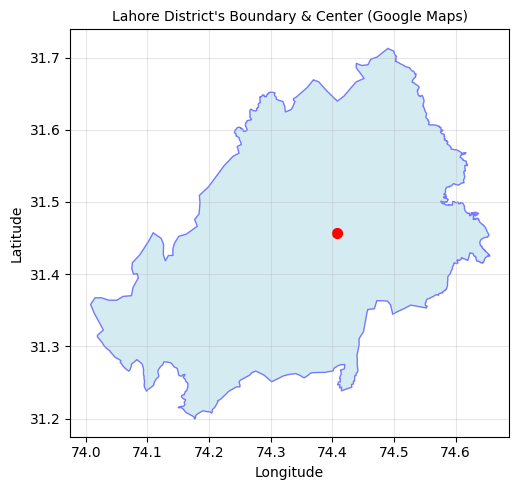

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))

lhr_boundary.plot(
    ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="Lahore District"
)
lhr_cntr_gdf.plot(ax=ax, color="red", markersize=50)

ax.set_title(
    "Lahore District's Boundary & Center (Google Maps)",
    fontsize=10,
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Extract UTM CRS for future use


In [4]:
utm_crs = lhr_cntr_gdf_utm.crs
print("UTM CRS:", utm_crs)

if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

UTM CRS: EPSG:32643


## Get Lahore's points of interest via OMSNX


In [7]:
pois = ox.features_from_place(
    LHR_NAME_STR,
    {
        "amenity": ["hospital", "university", "college"],
        "shop": ["supermarket", "mall"],
        "building": ["retail", "commercial"],
    },
)

pois.head(3)

geometry addr:city  \
element id                                               
node    271105745   POINT (74.3715 31.47673)    Lahore   
        272381690  POINT (74.34562 31.55025)       NaN   
        300856816  POINT (74.34611 31.52423)    Lahore   

                              addr:street   amenity emergency healthcare  \
element id                                                                 
node    271105745        St 29 Sec W Ph 3  hospital       yes   hospital   
        272381690                     NaN   college       NaN        NaN   
        300856816  Main Boulevard Gulberg       NaN       NaN        NaN   

                                           name addr:postcode opening_hours  \
element id                                                                    
node    271105745  DHA Medical Center Phase III           NaN           NaN   
        272381690             Aitchison College           NaN           NaN   
        300856816           Main Market Gulberg         54000    9am : 11pm   

                   shop  ... addr:full owner parking parking:capacity  \
element id               ...                                            
node    271105745   NaN  ...       NaN   NaN     NaN              NaN   
        272381690   NaN  ...       NaN   NaN     NaN              NaN   
        300856816  mall  ...       NaN   NaN     NaN              NaN   

                  building:ownership capacity:persons ramp:wheelchair  \
element id                                                              
node    271105745                NaN              NaN             NaN   
        272381690                NaN              NaN             NaN   
        300856816                NaN              NaN             NaN   

                  building:architecture year_of_construction postal_code  
element id                                                                
node    271105745                   NaN                  NaN         NaN  
        272381690                   NaN                  NaN         NaN  
        300856816                   NaN                  NaN         NaN  

[3 rows x 129 columns]

#### Feature engineering and Data Preparation (POIs)

Keep only the points of interest relevant to us, w/ all unnecessary columns removed.


In [ ]:
def filter_pois(df, conditions):
    return df[conditions][["geometry", "name"]].copy()


hospitals = filter_pois(pois, pois["amenity"] == "hospital").assign(type="hospital")
universities = filter_pois(
    pois, pois["amenity"].isin(["university", "college"])
).assign(type="education")
markets = filter_pois(
    pois,
    pois["shop"].isin(["supermarket", "mall"])
    | pois["building"].isin(["retail", "commercial"]),
).assign(type="market")

all_pois = gpd.GeoDataFrame(
    gpd.pd.concat([hospitals, universities, markets]), crs=pois.crs
)

pois = None

# Retain only the center of polygon/multipolygon for each point of interest
all_pois.geometry = all_pois.geometry.apply(
    lambda geom: (
        geom.centroid if geom.geom_type in ["Polygon", "MultiPolygon"] else geom
    )
)

if utm_crs is None:
    raise TypeError("`utm_crs` is none.")


all_pois = all_pois.to_crs(utm_crs)
all_pois.to_file(f"{OSMNX_DATA_DIR}/all-pois.gpkg", layer="pois", driver="GPKG")
all_pois.head(3)

geometry  \
element id                                          
node    271105745  POINT (440299.449 3482608.993)   
        526681507  POINT (434629.628 3485496.606)   
        563684371  POINT (437375.331 3486167.245)   

                                           name      type  
element id                                                 
node    271105745  DHA Medical Center Phase III  hospital  
        526681507              PU Health Center  hospital  
        563684371           متحده مسیحي روغتون.  hospital

#### Generate Graph of Road Network inside Lahore's Boundary


In [9]:
if os.path.exists(f"{OSMNX_DATA_DIR}/network.graphml"):
    print("Found Lahore's graph. Loading.")
    lhr_graph = ox.load_graphml(f"{OSMNX_DATA_DIR}/network.graphml")
else:
    print("Graph not found. Computing...")
    lhr_graph = ox.graph_from_polygon(  # downloads graph within bounds
        lhr_boundary.geometry.iloc[0],  # type: ignore | NOTE: lhr_boundary.crs has to be EPSG:4326
        network_type="drive",
        truncate_by_edge=True,
    )

    lhr_graph = ox.project_graph(lhr_graph, to_crs=utm_crs)
    ox.save_graphml(lhr_graph, filepath=f"{OSMNX_DATA_DIR}/network.graphml")

Found Lahore's graph. Loading.


In [10]:
if utm_crs is None:
    raise TypeError("`utm_crs` is none.")

lhr_boundary = lhr_boundary.to_crs(
    utm_crs
)  # Ensure boundary is in UTM CRS; must do this after plotting & graph generation.

#### Extract Edges and Major Roads


In [11]:
edges_gdf = ox.graph_to_gdfs(lhr_graph, nodes=False)
major_roads: GeoDataFrame = edges_gdf[
    edges_gdf["highway"].isin(["primary", "secondary", "trunk"])
]

major_roads.head(3)

,,,osmid,highway,lanes,maxspeed,name,oneway,reversed,length,geometry,tunnel,bridge,ref,access,junction,width
u,v,key,,,,,,,,,,,,,,,
59634015,8146995886,0,177946605,trunk,4,70,West Canal Bank Road,True,False,292.907737,"LINESTRING (431533.146 3483055.318, 431589.857...",NaN,NaN,NaN,NaN,NaN,NaN
8146995886,652438327,0,177946605,trunk,4,70,West Canal Bank Road,True,False,218.942848,"LINESTRING (431801.553 3483172.57, 431854.242 ...",NaN,NaN,NaN,NaN,NaN,NaN
59634249,59635978,0,177946605,trunk,4,70,West Canal Bank Road,True,False,209.427602,"LINESTRING (432374.204 3483474.119, 432550.859...",NaN,NaN,NaN,NaN,NaN,NaN


#### Plot Lahore w/ PoIs + Major Roads


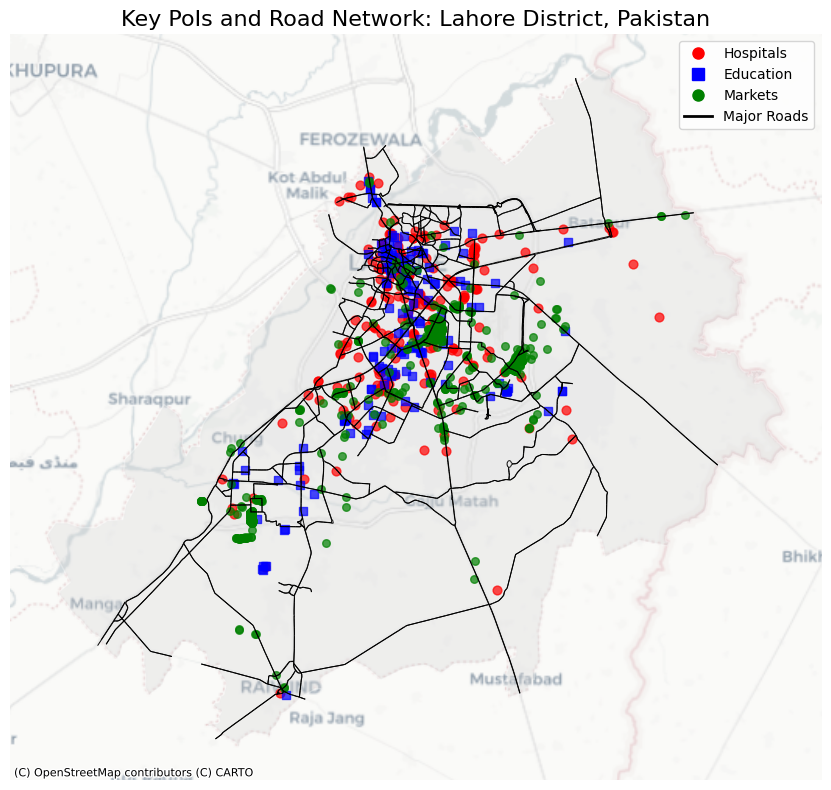

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

lhr_boundary.plot(ax=ax, color="lightgray", edgecolor="white", alpha=0.3)
major_roads.plot(ax=ax, color="black", linewidth=0.7)

poi_colors = {"hospital": "red", "education": "blue", "market": "green"}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois["type"] == ptype]
    subset.plot(
        ax=ax,
        color=color,
        markersize=30 + 10 * (ptype == "hospital"),
        alpha=0.7,
        marker="o" if ptype != "education" else "s",
    )

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)  # type: ignore

legend_elements = [
    Line2D([0], [0], color="red", lw=0, marker="o", markersize=8, label="Hospitals"),
    Line2D([0], [0], color="blue", lw=0, marker="s", markersize=8, label="Education"),
    Line2D([0], [0], color="green", lw=0, marker="o", markersize=8, label="Markets"),
    Line2D([0], [0], color="black", lw=2, label="Major Roads"),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_title(f"Key PoIs and Road Network: {LHR_NAME_STR}", fontsize=16)
ax.axis("off")

plt.tight_layout()
plt.savefig(f"{OSMNX_DATA_DIR}/lahore-poi-network.png", dpi=300)
plt.show()

#### Points of Interest + Graph Interpretation


In [13]:
print(f"Hospitals: {len(hospitals)}")
print(f"Education Institutions: {len(universities)}")
print(f"Markets: {len(markets)}")
print(f"Total POIs: {len(all_pois)}")
print()
print(f"Road Network: {len(edges_gdf)} edges")
print(f"Number of nodes: {len(lhr_graph.nodes)}")

Hospitals: 227
Education Institutions: 159
Markets: 804
Total POIs: 1190

Road Network: 378090 edges
Number of nodes: 145131


## Population: Discard Unnecessary Info Rows

pre-req: Worldpop's data has been downloaded
i.e only retain rows that fall within Lahore's boundary


In [14]:
CLIPPED_GPKG = f"{WORLDPOP_DATA_DIR}/worldpop_lahore_rows.gpkg"

if os.path.exists(CLIPPED_GPKG):
    print("Loading existing Lahore population density file.")
    lhr_pop_gdf = gpd.read_file(CLIPPED_GPKG)
else:
    print("Generating Lahore's population density in particular.")
    pk_pop_df = pd.read_csv(WORLDPOP_CSV_FPATH)

    pk_pop_gdf = gpd.GeoDataFrame(
        pk_pop_df,
        geometry=gpd.points_from_xy(pk_pop_df.X, pk_pop_df.Y),
        crs="EPSG:4326",  # for some godforsaken reason, using lhr_boundary.crs doesn't work here...
    )

    if not lhr_boundary.crs:
        raise RuntimeError("`boundary.crs` was None")

    pk_pop_gdf = pk_pop_gdf.to_crs(lhr_boundary.crs)
    lhr_pop_gdf = gpd.clip(pk_pop_gdf, lhr_boundary)
    lhr_pop_gdf = lhr_pop_gdf[lhr_pop_gdf["Z"] > 0]

    if len(lhr_pop_gdf) > 0:
        lhr_pop_gdf.to_file(CLIPPED_GPKG, driver="GPKG")
        print(f"Saved clipped data to {CLIPPED_GPKG}")
    else:
        print("Warning: No valid population data found in Lahore boundary.")


if not utm_crs:
    raise RuntimeError("`utm_crs` was None")

lhr_pop_gdf = lhr_pop_gdf.to_crs(utm_crs)

Loading existing Lahore population density file.


In [15]:
lhr_pop_gdf = lhr_pop_gdf.rename(
    columns={"X": "longitude", "Y": "latitude", "Z": "population"}
)

lhr_pop_gdf.head(3)

,longitude,latitude,population,geometry
0,74.202916,31.212083,746.548706,POINT (424073.354 3453380.183)
1,74.194583,31.212083,612.143555,POINT (423279.534 3453385.936)
2,74.186250,31.212083,733.004272,POINT (422485.712 3453391.749)


## Download: CityLines Data

Namely the Metro + Orange Line.


In [16]:
def download_json(url: str, fpath):
    print(f"Downloading {fname}...")
    import requests

    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(fpath, "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"Saved {fname} to {fpath}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {fname}: {e}")
        return None


for url, fname in CITYLINES_SRCS:
    fpath = os.path.join(CITYLINES_DATA_DIR, fname)

    if os.path.exists(fpath):
        print(f"{fname} already exists. Skipping download.")
        continue

    download_json(url, fpath)

lahore_sections.geojson already exists. Skipping download.
lahore_stations.geojson already exists. Skipping download.
lahore_lines_systems_and_modes.json already exists. Skipping download.


## Graph Augmentation


#### Load Metro + Speedo Data into GeoDataFrames


In [19]:
if utm_crs is None:
    raise TypeError("`utm_crs` is None")

metro_routes: GeoDataFrame = gpd.read_file(METRO_ROUTES_FPATH).to_crs(utm_crs)
df = gpd.read_file(
    SPEEDO_ROUTES_FPATH
)  # Of course this loads it into a normal Pandas DataFrame for some reason. Make Python make sense.
speedo_routes = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=utm_crs
)

In [18]:
metro_routes.head(2)

,id,klass,length,osm_id,osm_tags,osm_metadata,opening,lines,geometry
0,27066,Section,11900,818457073.0,"{""bridge"":""yes"",""electrified"":""rail"",""gauge"":""...","{""version"":9}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (433922.189 3491064.364, 433884.089..."
1,27067,Section,707,818457074.0,"{""bridge"":""yes"",""electrified"":""rail"",""gauge"":""...","{""version"":6}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (434190.08 3491698.902, 434186.221 ..."


In [23]:
speedo_routes.head(3)

,route_id,route_name,from,to,stop_index,stop_name,longitude,latitude,geometry
0,1_1,Route 1,Railway Station,Bhatti Chowk,1,Railway Station,74.33560046162094,31.57541491964004,POINT (74.336 31.575)
1,1_2,Route 1,Railway Station,Bhatti Chowk,3,Nawaz Sharif Hospital,74.32714822943394,31.58589557092073,POINT (74.327 31.586)
2,1_3,Route 1,Railway Station,Bhatti Chowk,4,Kashmiri Gate,74.32115706491254,31.58791366145399,POINT (74.321 31.588)


#### Add Metro Stops & Routes as Nodes & Edges in Graph


In [19]:
# Map rounded coordinate -> node_id so identical coords are reused across routes
coord2node = {}

new_nodes = 0
new_edges = 0


def extract_line_names(lines_field):
    # `lines` may be a list of dicts or a JSON string; return list of names
    if lines_field is None:
        return []
    if isinstance(lines_field, str):
        try:
            parsed = json.loads(lines_field)
            if isinstance(parsed, list):
                return [
                    d.get("line") for d in parsed if isinstance(d, dict) and "line" in d
                ]
            return []
        except Exception:
            return []
    if isinstance(lines_field, list):
        return [d.get("line") if isinstance(d, dict) else d for d in lines_field]
    return []


for _, row in metro_routes.iterrows():
    route_geom = row.geometry
    if route_geom is None:
        continue

    if route_geom.geom_type != "LineString":
        print(
            f"Warning: skipping route (id={row.get('id')}) with unexpected geometry type: {route_geom.geom_type}"
        )
        continue

    line_names = [ln for ln in extract_line_names(row.get("lines")) if ln]
    stop_coords = list(route_geom.coords)
    if len(stop_coords) < 2:
        continue

    prev_node = None

    for i, (stop_x, stop_y) in enumerate(stop_coords):
        key = (round(stop_x, 3), round(stop_y, 3))

        if key in coord2node:
            # Update existing node
            node_id = coord2node[key]
            # update lines attribute on existing node
            existing_lines = set(lhr_graph.nodes[node_id].get("lines", []))
            existing_lines.update(line_names)
            lhr_graph.nodes[node_id]["lines"] = list(existing_lines)
        else:
            # Insert new node
            rid = row.get("id")
            node_id = f"metro_{int(rid) if pd.notna(rid) else 'na'}_{i}"
            lhr_graph.add_node(
                node_id,
                x=stop_x,
                y=stop_y,
                geometry=Point(stop_x, stop_y),
                kind="metro_stop",
                lines=list(line_names),
            )
            coord2node[key] = node_id
            new_nodes += 1

        if prev_node is not None:
            # Insert new edge
            u, v = prev_node, node_id
            u_pt = (lhr_graph.nodes[u]["x"], lhr_graph.nodes[u]["y"])
            v_pt = (lhr_graph.nodes[v]["x"], lhr_graph.nodes[v]["y"])
            seg_geom = LineString([u_pt, v_pt])
            edge_attrs = {
                "geometry": seg_geom,
                "length": float(seg_geom.length),
                "type": "metro_route",
                "route_id": int(row.get("id")) if row.get("id") is not None else None,  # type: ignore
                "lines": list(line_names),
            }
            lhr_graph.add_edge(u, v, **edge_attrs)
            new_edges += 1

        prev_node = node_id

print(
    f"Inserted {new_nodes} new metro nodes and {new_edges} new directed edges into lhr_graph."
)

Inserted 521 new metro nodes and 519 new directed edges into lhr_graph.


In [20]:
nodes_gdf = ox.graph_to_gdfs(lhr_graph, edges=False)
nodes_gdf.tail(3)

,y,x,street_count,highway,ref,junction,railway,geometry,kind,lines
osmid,,,,,,,,,,
metro_27072_223,3.478541e+06,438751.066758,NaN,NaN,NaN,NaN,NaN,POINT (438751.067 3478540.814),metro_stop,[Lahore Metrobus]
metro_27072_224,3.477030e+06,438930.392253,NaN,NaN,NaN,NaN,NaN,POINT (438930.392 3477030.128),metro_stop,[Lahore Metrobus]
metro_27072_225,3.473886e+06,439311.319074,NaN,NaN,NaN,NaN,NaN,POINT (439311.319 3473885.618),metro_stop,[Lahore Metrobus]


#### Population Distribution Onto Nearby Graph Nodes


In [21]:
if os.path.exists(AGGR_GRAPH_PATH):
    print("Found aggregated graph. Skipping computation.")
else:
    print("No aggregated graph found. Generating population-augmented graph…")

    if lhr_pop_gdf.crs is None:
        raise TypeError("`lhr_pop_gdf.crs` is none.")

    nodes_gdf = nodes_gdf.to_crs(lhr_pop_gdf.crs)

    nodes_gdf["population"] = 0.0

    # brute-force redistribute population readings onto nodes
    for idx, pop_row in lhr_pop_gdf.iterrows():
        pop_point = pop_row.geometry
        pop_value = pop_row.population

        distances = nodes_gdf.geometry.distance(pop_point)
        nearby_nodes = nodes_gdf[distances <= POP_READING_RADIUS]

        if len(nearby_nodes) == 0:
            continue

        share = pop_value / len(nearby_nodes)
        nodes_gdf.loc[nearby_nodes.index, "population"] += share

    nx.set_node_attributes(
        lhr_graph, nodes_gdf["population"].to_dict(), name="population"
    )

No aggregated graph found. Generating population-augmented graph…


#### Compute Distance to Nearest Public Transit Stop


In [22]:
if os.path.exists(AGGR_GRAPH_PATH):
    print("Found aggregated graph. Skipping computation.")
else:
    # Extract stop nodes' coordinates
    stop_nodes = [
        (data["x"], data["y"])
        for _, data in lhr_graph.nodes(data=True)
        if data.get("kind") == "metro_stop"
    ]

    stop_points = np.array(stop_nodes)  # shape (N_stops, 2)

    for n, data in lhr_graph.nodes(data=True):
        x, y = data["x"], data["y"]
        if not stop_points.size:
            nearest_dist = np.nan
        else:
            dists = np.sqrt((stop_points[:, 0] - x) ** 2 + (stop_points[:, 1] - y) ** 2)
            nearest_dist = dists.min()
        lhr_graph.nodes[n]["distance_to_nearest_stop"] = nearest_dist

In [23]:
if not os.path.exists(AGGR_GRAPH_PATH):
    # NOTE: load the following graph w/ Networkx.
    # It won't load w/ OSMNX because of the added string IDs.
    ox.save_graphml(lhr_graph, AGGR_GRAPH_PATH)
    print(f"Saved aggregated graph to: {AGGR_GRAPH_PATH}")

Saved aggregated graph to: ../data/graphs/aggregated.graphml
